In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
def show_tensor_images(image_tensor,num_images=25,size=(1,28,28),nrow=5,show=True):
    image_tensor=(image_tensor+1)/2
    image_unflat=image_tensor.detach().cpu()
    image_grid=make_grid(image_unflat[:num_images],nrow=nrow)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    if show:
        plt.show()
        

In [ ]:
class Generator(nn.Module):
    
    def __init__(self,input_dim=10,im_chan=1,hidden_dim=64):
        super(Generator,self).__init__()
        self.input_dim=input_dim
        self.gen=nn.Sequential(
            self.make_gen_block(input_dim,hidden_dim*4),
            self.make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            self.make_gen_block(hidden_dim*2,hidden_dim),
            self.make_gen_block(hidden_dim,im_chan,kernel_size=4,final_layer=True)
        
        )
    def make_gen_block(self,input_channels,output_channels,kernel_size=3,stride=2,final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
            nn.Tanh(),
            )
        
    def forward(self,x):
        x=x.view(len(x),self.input_dim,1,1)
        return self.gen(x)
    
        

In [ ]:
def get_noise(n_samples,input_dim,device='cpu'):
    return torch.randn(n_samples,input_dim,device=device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,im_chan=1,hidden_dim=64,c_dim=10):
        super(Discriminator,self).__init__()
        self.disc=nn.Sequential(
        self.make_disc_block(im_chan,hidden_dim),
            self.make_disc_block(hidden_dim,hidden_dim*2),
        )
        self.d_layer=self.make_disc_block(hidden_dim*2,1,final_layer=True)
        self.q_layer=nn.Sequential(
        self.make_disc_block(hidden_dim*2,hidden_dim*2),
        self.make_disc_block(hidden_dim*2,2*c_dim,kernel_size=1,final_layer=True))
        
    def make_disc_block(self,input_channels,output_channels,kernel_size=4,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
    def forward(self,image):
        intermediate_pred=self.disc(image)
        disc_pred=self.d_layer(intermediate_pred)
        q_pred=self.q_layer(intermediate_pred)
        
        return disc_pred.view(len(disc_pred), -1), q_pred.view(len(q_pred), -1)
        

In [ ]:
def combine_vector(x,y):
    return torch.cat([x.float(),y.float()],1)

In [ ]:
from torch.distributions.normal import Normal
adv_criterion=nn.BCEWithLogitsLoss()
c_criterion=lambda c_true,mean,logvar: Normal(mean,logvar.exp()).log_prob(c_true).mean()
c_lambda=0.1
mnist_shape=(1,28,28)
n_epochs=80
z_dim=64
c_dim=2
display_step=500
batch_size=128
d_lr=2e-4
g_lr=1e-3
device='cuda'
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])

dataloader=DataLoader(
MNIST("P:\\dataset\\",transform=transform),
batch_size=batch_size,
    shuffle=True
)

In [ ]:
gen=Generator(input_dim=z_dim+c_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=g_lr)
disc=Discriminator(im_chan=mnist_shape[0],c_dim=c_dim).to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=d_lr)

def weigts_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
        torch.nn.init.constant_(m.bias,0)


gen=gen.apply(weigts_init)
disc=disc.apply(weigts_init)

Epoch 23, step 11000: Generator loss: 1.2150433698892593, discriminator loss: 0.5364094717502594


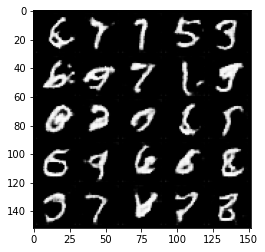

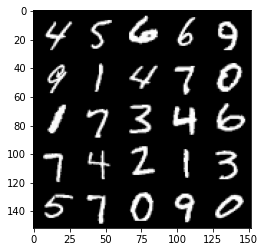

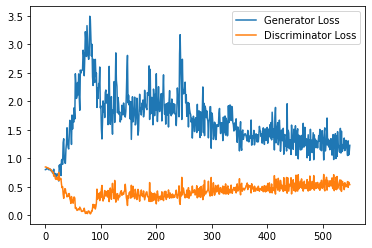

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 1.3567353891134262, discriminator loss: 0.5547190129458904


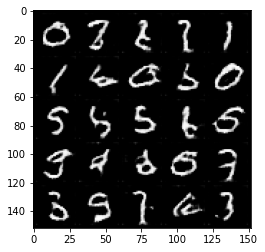

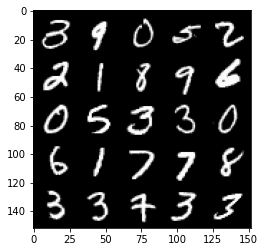

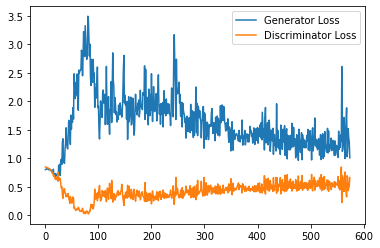

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 1.1397545145750045, discriminator loss: 0.5656984550952912


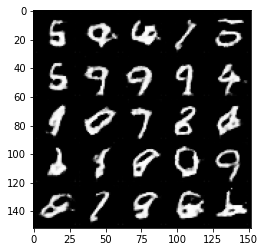

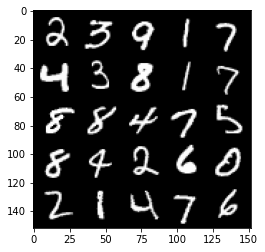

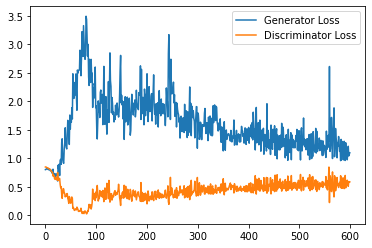

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 1.1344747574329377, discriminator loss: 0.5586674401164055


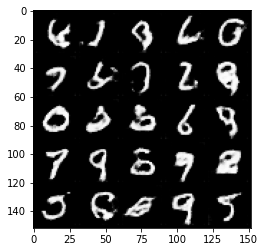

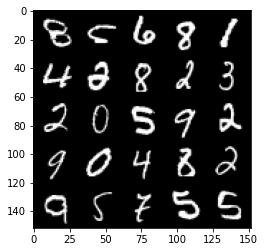

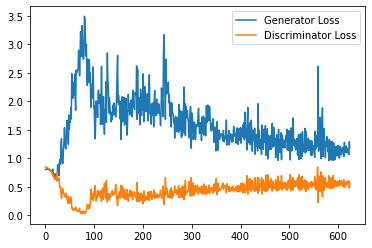

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 1.2754112207889556, discriminator loss: 0.5565434914827346


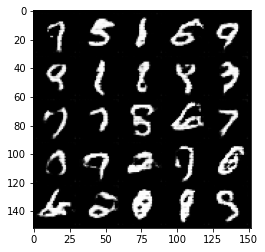

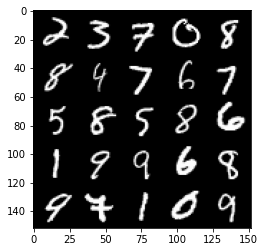

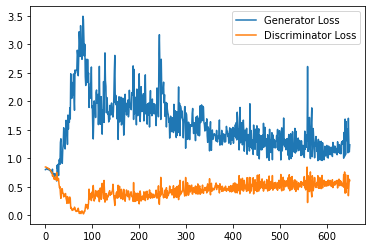

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 1.1449703251123429, discriminator loss: 0.562545830488205


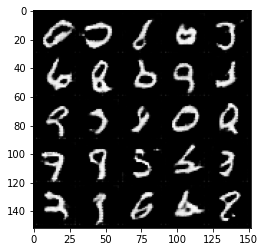

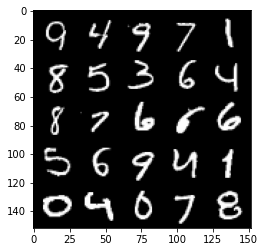

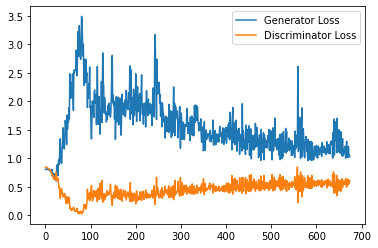

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 1.0914590289592743, discriminator loss: 0.5771675370931625


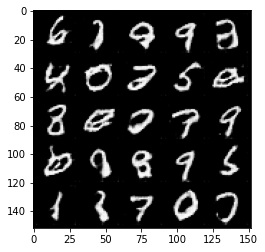

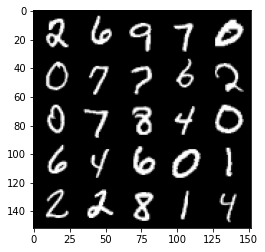

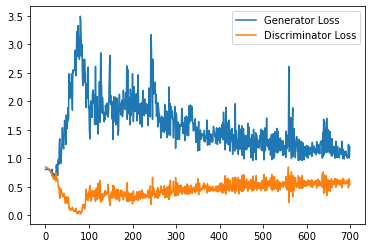

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 1.1297958530187606, discriminator loss: 0.5826903165578842


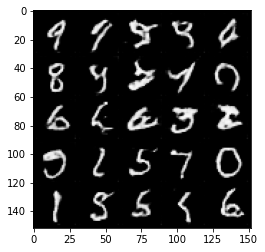

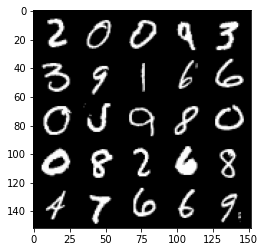

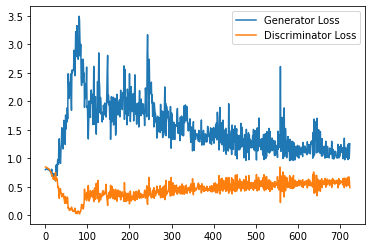

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 1.0563590058088304, discriminator loss: 0.5813439126610755


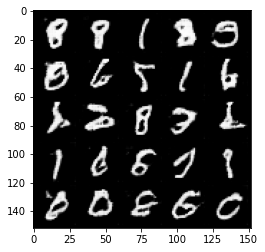

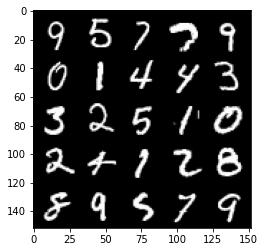

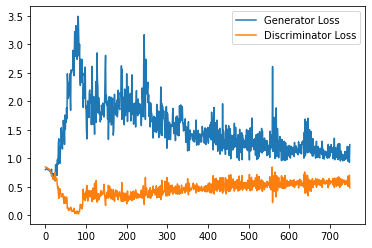

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 1.1030269553661347, discriminator loss: 0.5742475603222847


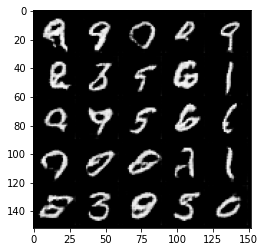

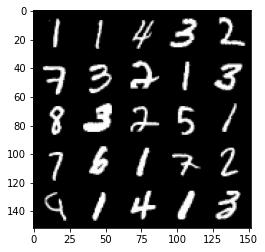

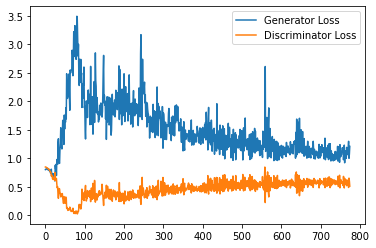

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 1.1856599768400193, discriminator loss: 0.583835359275341


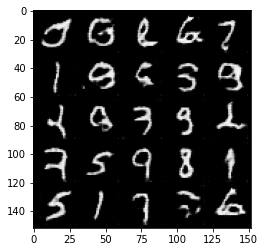

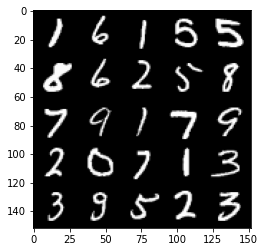

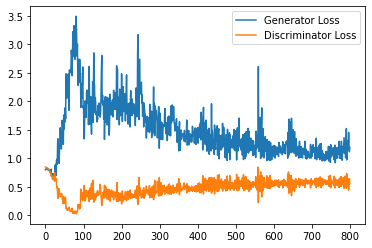

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 1.0948303515911102, discriminator loss: 0.5896826605796814


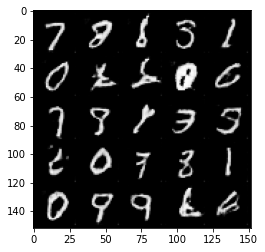

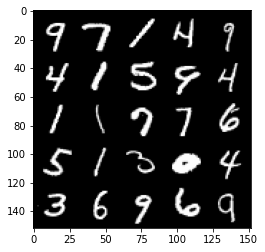

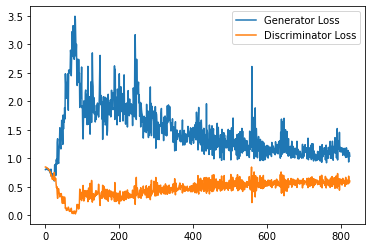

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 1.0103936022520066, discriminator loss: 0.5855441076159478


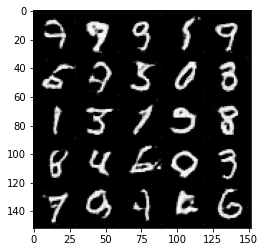

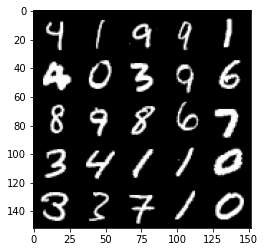

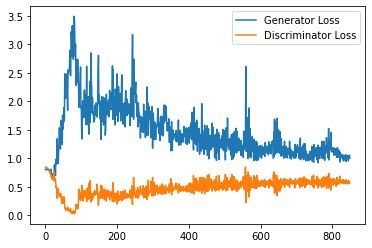

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 1.0753322147130966, discriminator loss: 0.5900029525160789


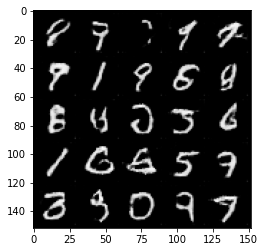

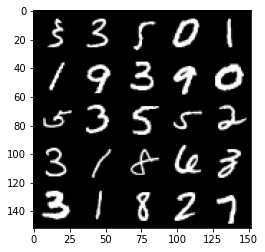

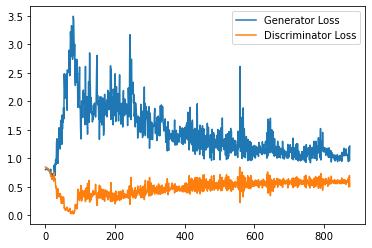

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 1.0229539217948913, discriminator loss: 0.593023639857769


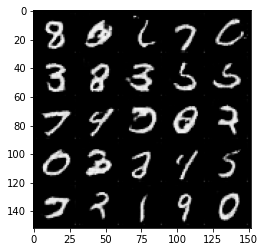

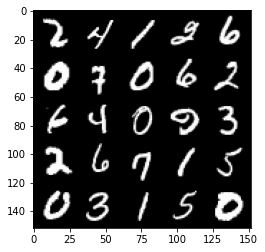

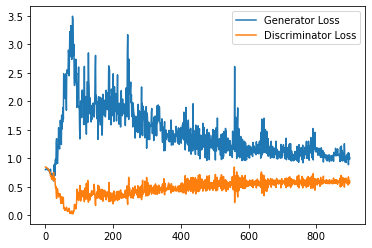

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 1.0185809177160263, discriminator loss: 0.5892999193072319


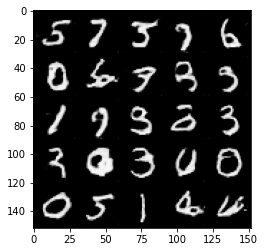

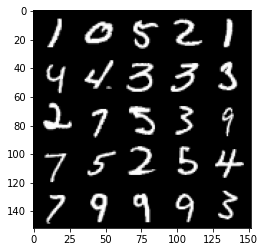

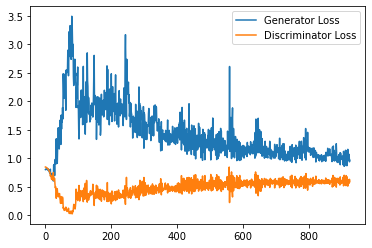

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 1.0173567554950713, discriminator loss: 0.5832046704888344


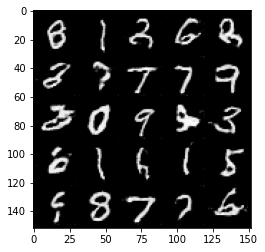

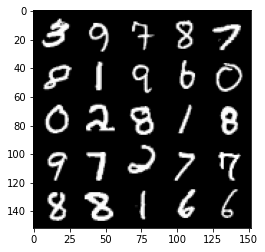

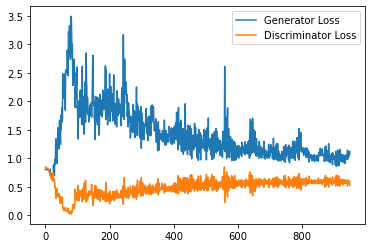

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 1.0389663252830506, discriminator loss: 0.5855377614498138


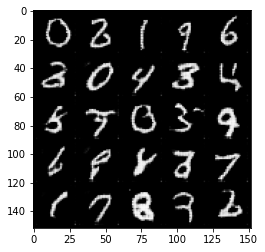

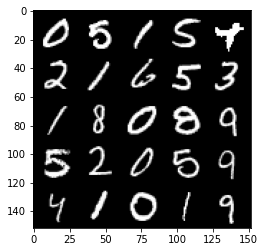

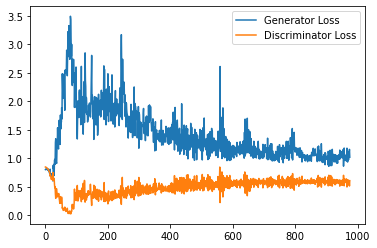

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 1.0769506450891495, discriminator loss: 0.57806487262249


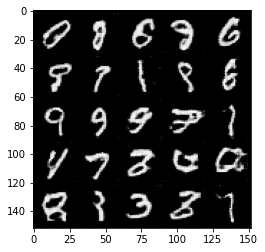

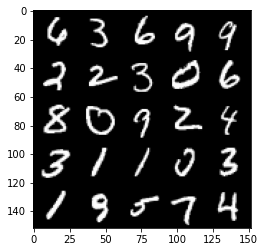

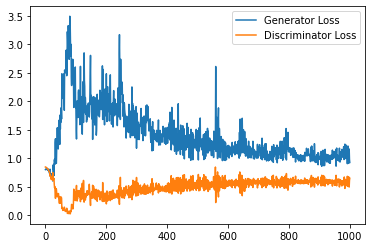

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 1.0175824015140533, discriminator loss: 0.5842052509188652


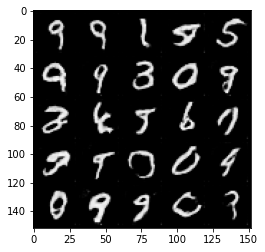

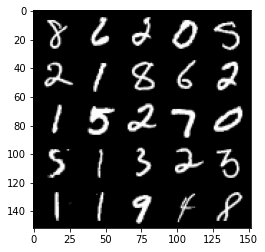

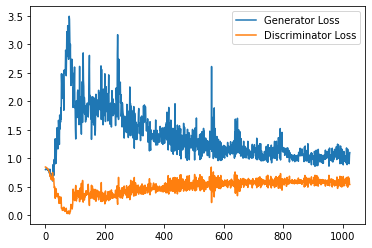

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 1.0417482345104216, discriminator loss: 0.5924977011084557


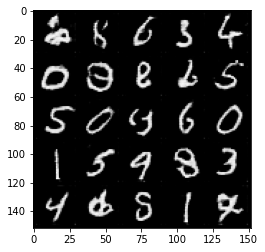

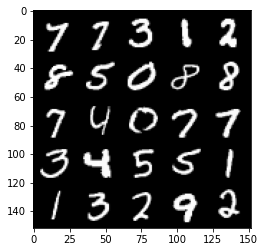

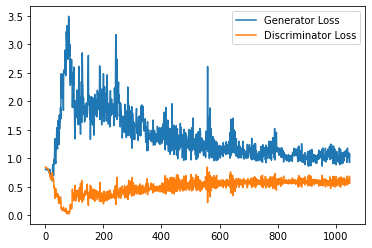

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 0.9805347291231156, discriminator loss: 0.5869957860708237


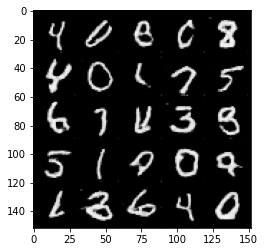

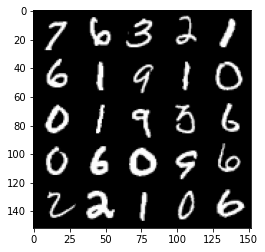

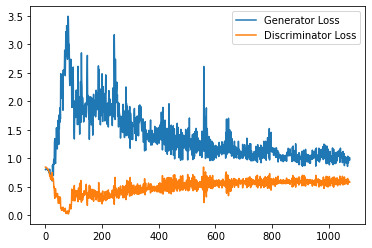

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 1.006769713163376, discriminator loss: 0.5859853601455689


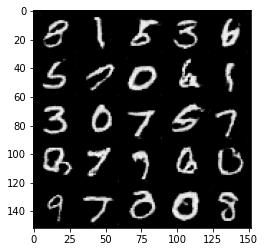

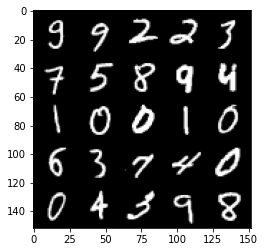

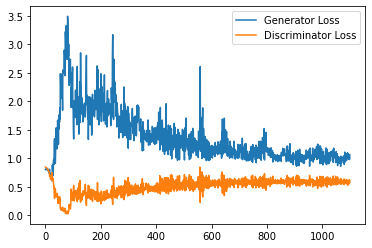

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 1.0314168776273727, discriminator loss: 0.5830454000234604


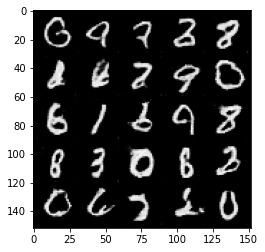

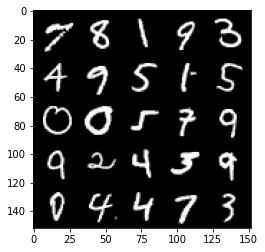

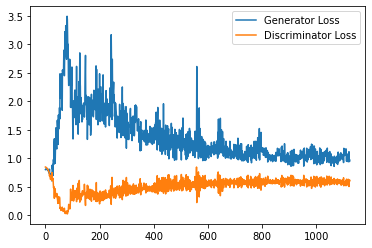

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 0.9790251719951629, discriminator loss: 0.5845202327370643


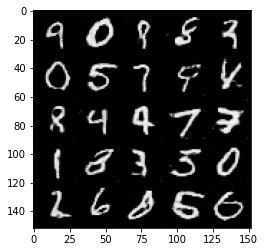

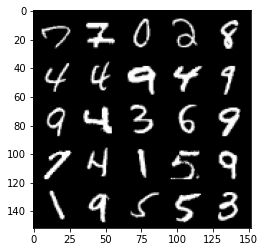

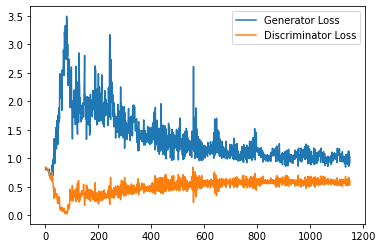

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50, step 23500: Generator loss: 1.008439032435417, discriminator loss: 0.5808917447328568


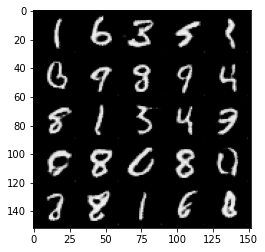

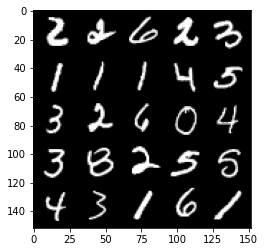

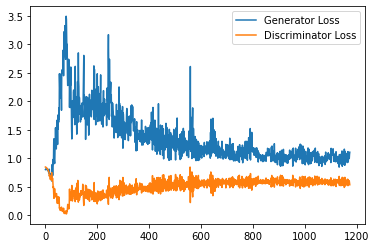

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51, step 24000: Generator loss: 0.9923726266622543, discriminator loss: 0.5840331397652626


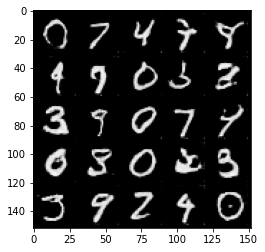

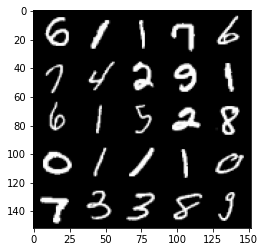

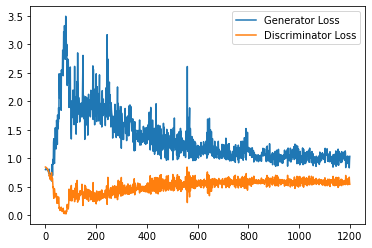

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52, step 24500: Generator loss: 0.9856206790208817, discriminator loss: 0.5773776286244392


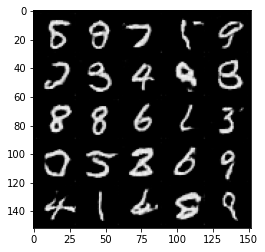

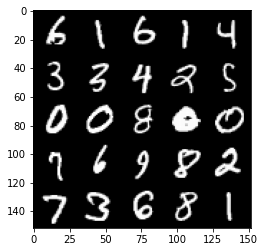

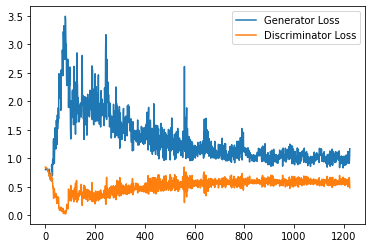

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53, step 25000: Generator loss: 1.0184324898719788, discriminator loss: 0.5812919782400131


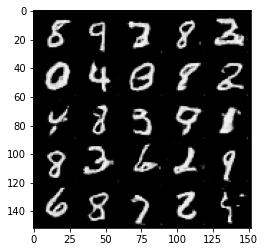

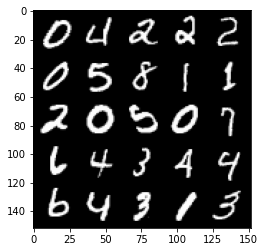

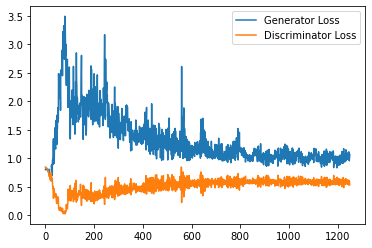

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54, step 25500: Generator loss: 1.0119335627555848, discriminator loss: 0.5763517227172852


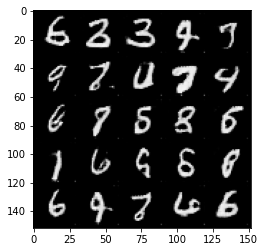

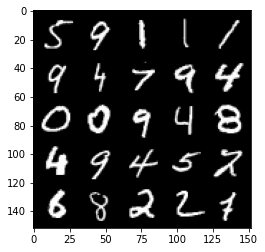

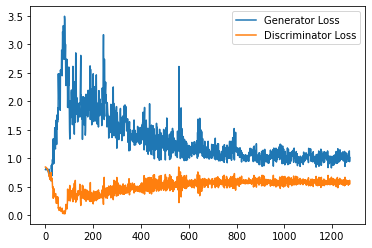

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55, step 26000: Generator loss: 0.989299048423767, discriminator loss: 0.5750352635979652


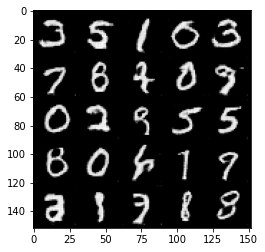

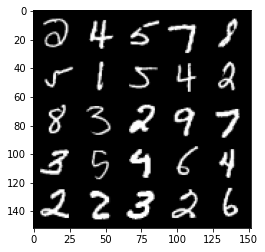

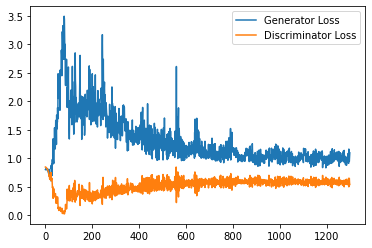

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56, step 26500: Generator loss: 1.0199853191375732, discriminator loss: 0.5793524994850159


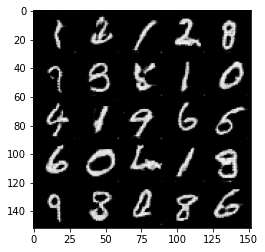

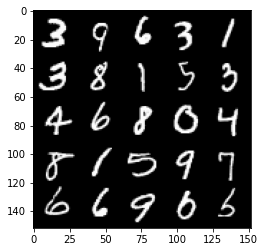

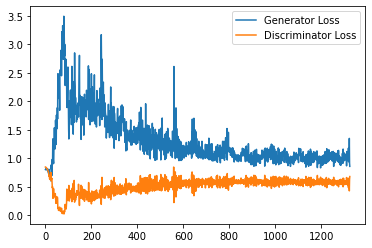

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57, step 27000: Generator loss: 1.0025993659496308, discriminator loss: 0.5743113161921501


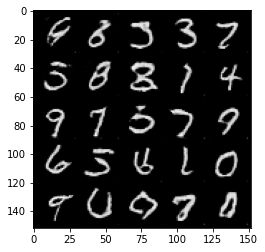

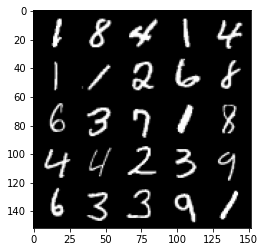

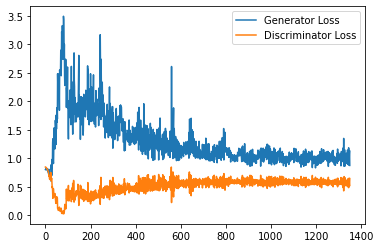

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58, step 27500: Generator loss: 0.9901691457033157, discriminator loss: 0.576090223789215


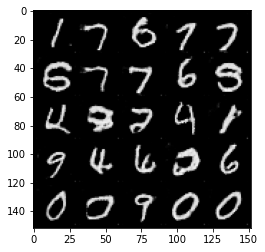

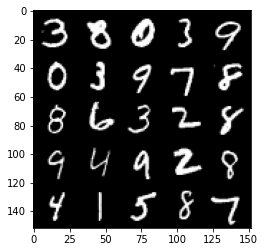

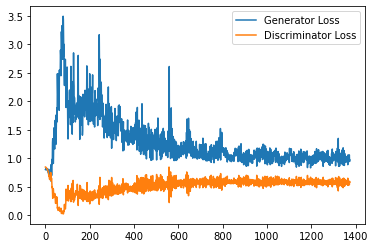

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59, step 28000: Generator loss: 1.0386814423799515, discriminator loss: 0.5677939649224282


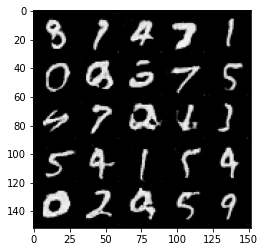

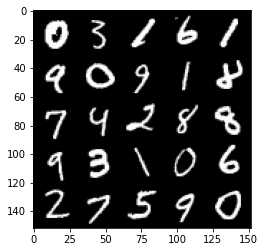

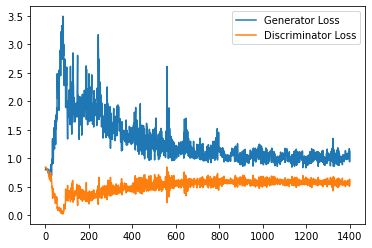

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60, step 28500: Generator loss: 1.0012256673574447, discriminator loss: 0.5740787281394005


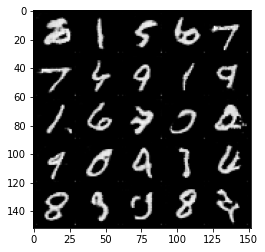

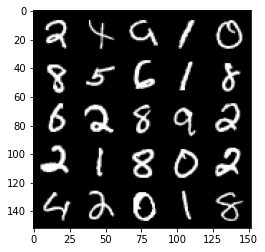

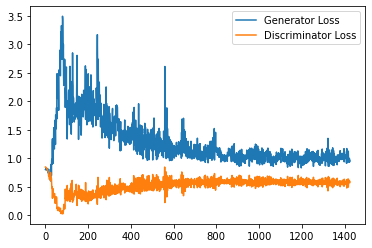

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61, step 29000: Generator loss: 0.9790790740251542, discriminator loss: 0.5735979360342026


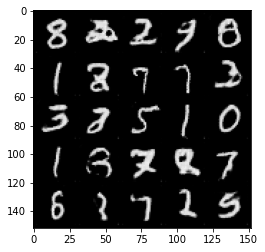

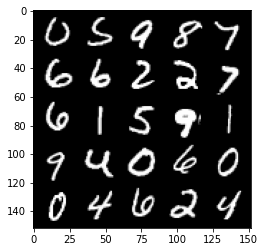

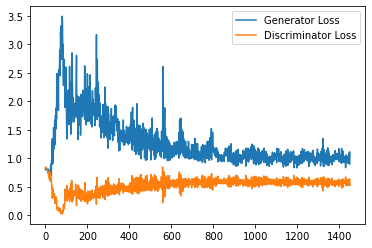

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62, step 29500: Generator loss: 1.0207709243297578, discriminator loss: 0.5703729633688926


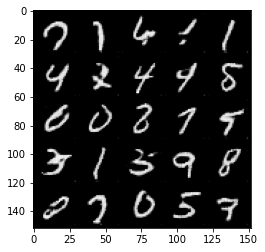

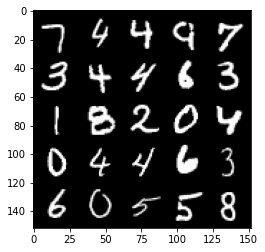

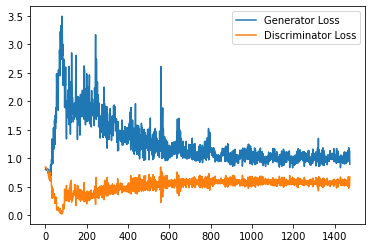

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63, step 30000: Generator loss: 1.0247439949512482, discriminator loss: 0.571486514210701


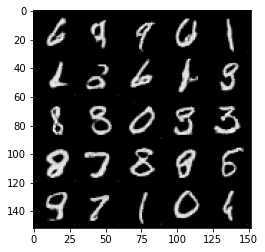

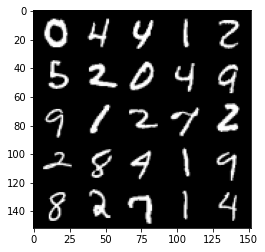

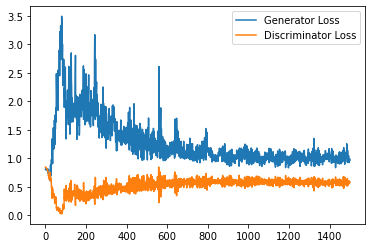

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65, step 30500: Generator loss: 0.9591460993289948, discriminator loss: 0.5771912060976029


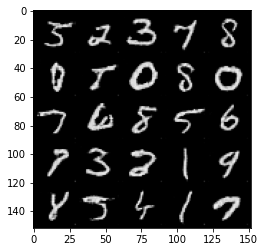

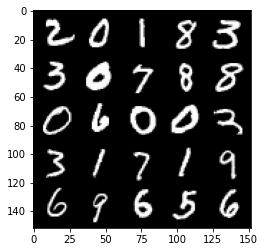

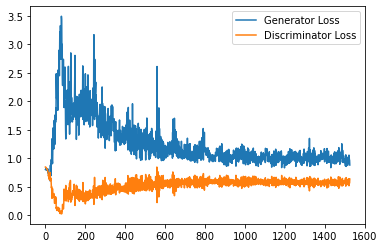

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66, step 31000: Generator loss: 1.0162069309949875, discriminator loss: 0.5696636056303978


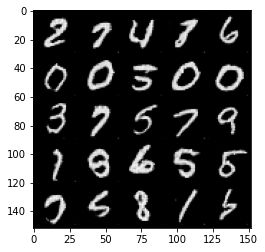

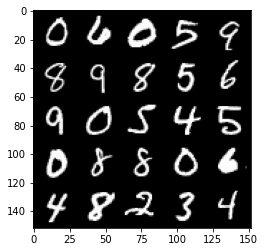

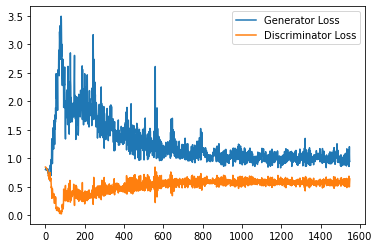

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67, step 31500: Generator loss: 0.986625018954277, discriminator loss: 0.5735586145520211


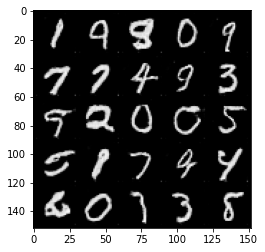

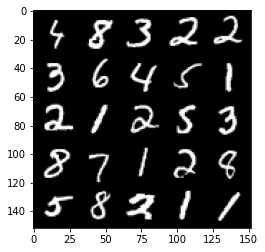

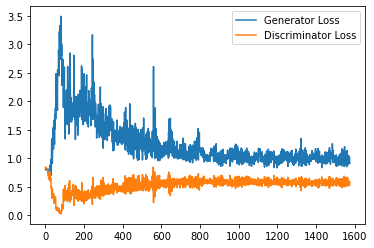

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68, step 32000: Generator loss: 0.994178310751915, discriminator loss: 0.5741655628085136


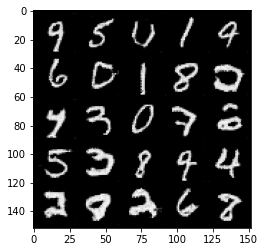

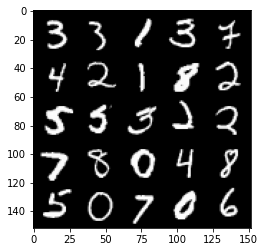

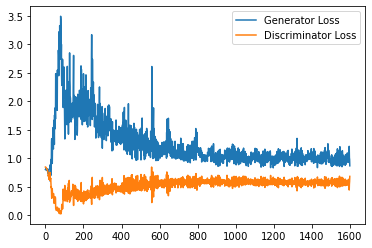

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69, step 32500: Generator loss: 1.0170223561525344, discriminator loss: 0.5643638225197792


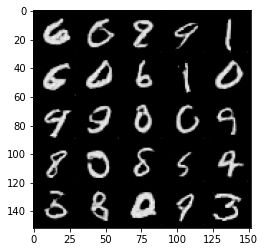

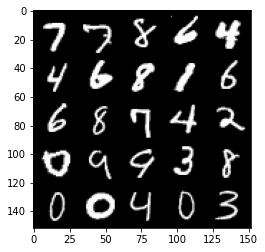

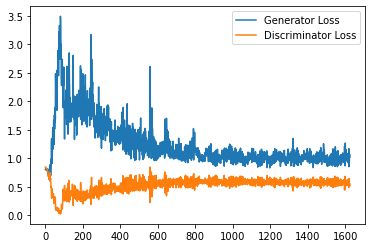

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
cur_step=0
generator_losses=[]
discriminator_losses=[]

for epoch in range(n_epochs):
    for real,_ in tqdm(dataloader):
        cur_batch_size=len(real)
        real=real.to(device)
        
        c_labels=get_noise(cur_batch_size,c_dim,device=device)
        
        disc_opt.zero_grad()
        fake_noise=get_noise(cur_batch_size,z_dim,device=device)
        noise_and_c=combine_vector(fake_noise,c_labels)
        fake=gen(noise_and_c)
        disc_fake_pred,disc_q_pred=disc(fake.detach())
        disc_q_mean=disc_q_pred[:,:c_dim]
        disc_q_logvar=disc_q_pred[:,c_dim:]
        mutual_information=c_criterion(c_labels,disc_q_mean,disc_q_logvar)
        
        disc_real_pred,_=disc(real)
        disc_fake_loss=adv_criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_loss=adv_criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        
        disc_loss=(disc_real_loss+disc_fake_loss)/2 - c_lambda*mutual_information
        disc_loss.backward(retain_graph=True)
        
        disc_opt.step()
        
        discriminator_losses+=[disc_loss.item()]
        
        
        gen_opt.zero_grad()
        disc_fake_pred,disc_q_pred=disc(fake)
        disc_q_mean=disc_q_pred[:,:c_dim]
        disc_q_logvar=disc_q_pred[:,c_dim:]
        
        mutual_information=c_criterion(c_labels,disc_q_mean,disc_q_logvar)
        gen_loss=adv_criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))-c_lambda*mutual_information
        gen_loss.backward()
        gen_opt.step()
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1

In [ ]:
gen=gen.eval()